In [20]:
import torch
import timm

In [21]:
import  torch.nn as nn
import torch.optim as optim
from glob import glob
import os

In [22]:
from PIL import Image
from torch.utils.data import DataLoader,random_split,Dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,confusion_matrix,ConfusionMatrixDisplay

In [23]:
class customdataset(Dataset):
    def __init__(self,root,transform=None):
        self.paths=sorted(glob(f"{root}/*/*"))
        self.transform=transform
        self.class_names=sorted(os.listdir(root))
        self.class_to_idx={cls:i for i,cls in enumerate(self.class_names)}
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,idx):
        path=self.paths[idx]
        img=Image.open(path).convert("RGB")
        label_name=os.path.basename(os.path.dirname(path))
        label=self.class_to_idx[label_name]
        if self.transform:
            img=self.transform(img)
        return img,label

In [24]:
from torchvision import transforms as T

In [25]:

root=r"D:\lungdisease\Lung X-Ray Image"

In [26]:
transform=T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
dataset=customdataset(root,transform)
n_total=len(dataset)
n_train=int(0.9*n_total)
n_val=int(0.05*n_total)
n_test=n_total-n_train-n_val

In [27]:
train_ds,val_ds,test_ds=random_split(dataset,[n_train,n_val,n_test])
train_dl=DataLoader(train_ds,batch_size=32,shuffle=True)
val_dl=DataLoader(val_ds,batch_size=32)
test_dl=DataLoader(test_ds,batch_size=1)
print(f"Train:{len(train_dl)},test:{len(test_dl)},validation:{len(val_dl)}")

Train:98,test:175,validation:6


In [28]:
device="cuda" if torch.cuda.is_available() else "cpu"
model=timm.create_model("rexnet_150",pretrained=True,num_classes=len(dataset.class_names))
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

In [29]:
train_losses,val_losses=[],[]
train_accuracies,val_accuracies=[],[]
train_f1s,val_f1s=[],[]
for epoch in range(5):
    model.train()
    running_loss,correct=0,0
    all_preds,all_labels=[],[]
    for imgs,labels in train_dl:
        imgs,labels=imgs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(imgs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        preds=outputs.argmax(1)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    train_loss=running_loss/len(train_dl)
    train_acc=correct/len(train_ds)
    train_f1=f1_score(all_labels,all_preds,average="macro")
    model.eval()
    val_loss, val_correct = 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_dl)
    val_acc = val_correct / len(val_ds)
    val_f1 = f1_score(val_labels, val_preds, average="macro")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.3f}, Train Acc={train_acc:.3f}, Train F1={train_f1:.3f}, "
          f"Val Loss={val_loss:.3f}, Val Acc={val_acc:.3f}, Val F1={val_f1:.3f}")


Epoch 1: Train Loss=0.698, Train Acc=0.852, Train F1=0.855, Val Loss=0.426, Val Acc=0.890, Val F1=0.891
Epoch 2: Train Loss=0.249, Train Acc=0.922, Train F1=0.924, Val Loss=0.469, Val Acc=0.908, Val F1=0.908
Epoch 3: Train Loss=0.123, Train Acc=0.961, Train F1=0.962, Val Loss=0.500, Val Acc=0.873, Val F1=0.870
Epoch 4: Train Loss=0.091, Train Acc=0.966, Train F1=0.967, Val Loss=0.747, Val Acc=0.902, Val F1=0.902
Epoch 5: Train Loss=0.111, Train Acc=0.968, Train F1=0.969, Val Loss=0.341, Val Acc=0.913, Val F1=0.913


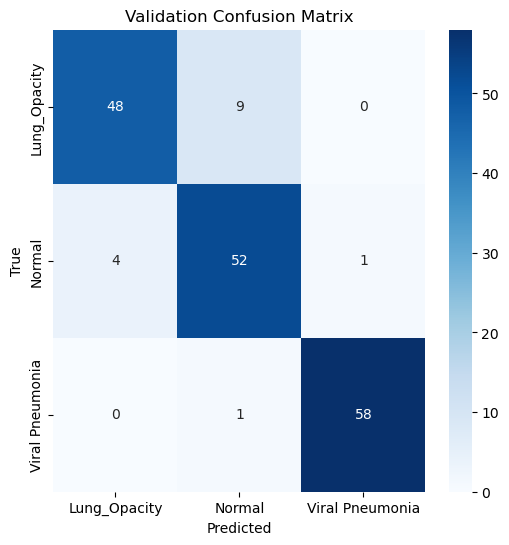

In [30]:
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [36]:
pred_img=r"D:\lungdisease\Lung X-Ray Image\Lung_Opacity\11.jpg"

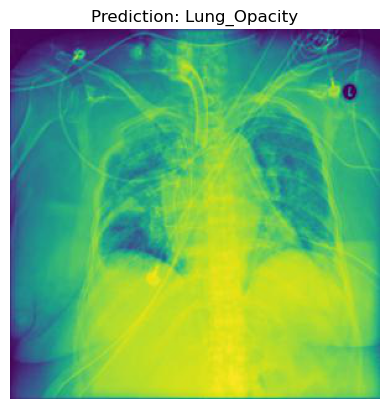

'Lung_Opacity'

In [37]:
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
        pred = out.argmax(1).item()
    plt.imshow(img)
    plt.title(f"Prediction: {dataset.class_names[pred]}")
    plt.axis("off")
    plt.show()
    return dataset.class_names[pred]
predict_image(pred_img)

In [33]:
torch.save(model, "full_model.pth")
